## XGBoost Implementation with Shapley Values for Metabolites Project

In [5]:
! pip3 install --user pandas
! pip3 install --user xgboost
! pip3 install --user xlrd

     |████████████████████████████████| 103 kB 1.8 MB/s eta 0:00:01


##### importing packages to use

In [1]:
import pandas as pd
import xgboost as xgb
import sklearn
import matplotlib
import shap
from xgboost import cv
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold

##### reading in data

In [2]:
wide_data = pd.read_excel('wide_data_xgb.xlsx')
long_data = pd.read_excel('long_data_xgb.xlsx')

In [16]:
wide_data.head()

,Unnamed: 0,treatment,metabolite_11.1,metabolite_42.1,metabolite_104.1,metabolite_233.1,metabolite_262.1,metabolite_270.1,metabolite_275.1,metabolite_339.1,...,metabolite_551.4,metabolite_29.4,metabolite_86.4,metabolite_212.4,metabolite_245.4,metabolite_341.4,metabolite_343.4,metabolite_411.4,metabolite_450.4,metabolite_509.4
0,1,0,107712,174922,2033035,638480,96844480,185511.0,44829356,10896387,...,48674.0,176664,31976566,436997,2989876,3832492,178270.0,1085779,457745,496484
1,5,0,89298,199346,2399116,782783,95742656,191858.0,43247072,8679545,...,164021.0,113289,12526932,662598,3636800,3545715,322450.0,183341,746789,293632
2,9,0,113656,141132,1660535,698178,94786280,179194.0,57224812,3061285,...,63030.0,137931,5964986,932946,4086819,4568314,386725.0,260856,298775,547454
3,13,0,231944,219181,2980075,1226788,121669056,292780.0,61433928,10906684,...,171561.0,371431,18549456,165326,12325325,12310353,621101.0,1398064,150076,141661
4,17,0,304848,141214,1319154,1352076,140278704,55952.0,42229124,14867588,...,134276.0,379738,11944811,245769,10527124,9956749,547430.0,1682148,391481,500223


In [17]:
long_data.head()

,Unnamed: 0,treatment,time,metabolite_11,metabolite_42,metabolite_104,metabolite_233,metabolite_262,metabolite_270,metabolite_275,...,metabolite_551,metabolite_29,metabolite_86,metabolite_212,metabolite_245,metabolite_341,metabolite_343,metabolite_411,metabolite_450,metabolite_509
0,1,0,1,107712,174922,2033035,638480,96844480,185511.0,44829356,...,2011404.0,714915,55690996,150518.0,10596151,10086547,505552.0,2550362,171635,504379
1,2,0,1,89298,199346,2399116,782783,95742656,191858.0,43247072,...,492960.0,690560,29008762,488712.0,11977319,15733366,509248.0,1931692,292254,137926
2,3,0,1,113656,141132,1660535,698178,94786280,179194.0,57224812,...,1775706.0,847803,13128987,564375.0,11544534,12464034,498427.0,2463908,369308,272051
3,4,0,1,231944,219181,2980075,1226788,121669056,292780.0,61433928,...,3616084.0,444471,34524008,120184.0,12969681,17100964,817777.0,2276824,257079,195217
4,5,0,1,304848,141214,1319154,1352076,140278704,55952.0,42229124,...,292102.0,1179626,45873380,122080.0,13184844,17867948,801399.0,2779364,180378,230305


##### converting some features into factors before we build xgboost models! (and getting rid of uncessary columns

In [3]:
# converting variables into categorical variables
wide_data['treatment'] = wide_data.treatment.astype('category')
long_data['treatment'] = long_data.treatment.astype('category')
long_data['time'] = long_data.time.astype('category')

In [4]:
wide_data.columns[0]
long_data.columns[0]

'Unnamed: 0'

In [4]:
# deleting unnamed col
'''wide_data.drop(wide_data.columns[0], axis=1)
long_data.drop(long_data.columns[0], axis=1)'''

del wide_data['Unnamed: 0']
del long_data['Unnamed: 0']

#### performing hyperparameter tuning!

In [19]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [16]:
# defining parameter grids
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(50, 101, 25),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, .3, .5]
}

parameters_rscv = {
    "learning_rate": [0.1, 0.01, 0.001],
    "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
    "max_depth": [2, 4, 7, 10],
    "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
    "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
    "reg_alpha": [0, 0.5, 1],
    "reg_lambda": [1, 1.5, 2, 3, 4.5],
    "min_child_weight": [1, 3, 5, 7],
    "n_estimators": [20, 50, 80]
}

parameters_gse = {                                  # gse = grid search exhaustive
    "gamma" : [0.01, 0.1, 0.5, 1, 1.5],
    "max_depth": [2, 4, 7, 10],
    "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
    "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
    "reg_lambda": [1, 1.5, 3],
    "n_estimators": [20, 50, 80]
}

In [5]:
# forming X and y
X_wide = wide_data.iloc[:,1:len(wide_data.columns)]
y_wide = wide_data.iloc[:,0]

X_long = long_data.iloc[:,1:len(long_data.columns)]
y_long = long_data.iloc[:,0]

In [9]:
# random search cv
xgb_rscv = RandomizedSearchCV(estimator, param_distributions = parameters_rscv, scoring = "f1_micro",
                             verbose = 3, random_state = 7)

In [10]:
# grid search cv
grid_search = GridSearchCV(estimator=estimator, param_grid = parameters, scoring = 'f1_micro')

In [20]:
# exhaustive grid search cv
grid_search_all = GridSearchCV(estimator=estimator, param_grid = parameters_gse, scoring = 'f1_micro')

In [13]:
grid_search.fit(X_wide, y_wide)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=None, tree_method=None

In [14]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [15]:
model_xgboost = xgb_rscv.fit(X_wide, y_wide)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] subsample=0.2, reg_lambda=3, reg_alpha=0.5, n_estimators=80, min_child_weight=3, max_depth=2, learning_rate=0.001, gamma=1.5, colsample_bytree=0.3 
[CV]  subsample=0.2, reg_lambda=3, reg_alpha=0.5, n_estimators=80, min_child_weight=3, max_depth=2, learning_rate=0.001, gamma=1.5, colsample_bytree=0.3, score=0.333, total=   0.0s
[CV] subsample=0.2, reg_lambda=3, reg_alpha=0.5, n_estimators=80, min_child_weight=3, max_depth=2, learning_rate=0.001, gamma=1.5, colsample_bytree=0.3 
[CV]  subsample=0.2, reg_lambda=3, reg_alpha=0.5, n_estimators=80, min_child_weight=3, max_depth=2, learning_rate=0.001, gamma=1.5, colsample_bytree=0.3, score=0.333, total=   0.0s
[CV] subsample=0.2, reg_lambda=3, reg_alpha=0.5, n_estimators=80, min_child_weight=3, max_depth=2, learning_rate=0.001, gamma=1.5, colsample_bytree=0.3 
[CV]  subsample=0.2, reg_lambda=3, reg_alpha=0.5, n_estimators=80, min_child_weight=3, max_depth=2, learning_rate=0.00

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  subsample=0.5, reg_lambda=3, reg_alpha=0, n_estimators=80, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.3, score=0.333, total=   0.0s
[CV] subsample=0.5, reg_lambda=3, reg_alpha=0, n_estimators=80, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.3 
[CV]  subsample=0.5, reg_lambda=3, reg_alpha=0, n_estimators=80, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.3, score=0.333, total=   0.0s
[CV] subsample=0.5, reg_lambda=3, reg_alpha=0, n_estimators=80, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.3 
[CV]  subsample=0.5, reg_lambda=3, reg_alpha=0, n_estimators=80, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.3, score=0.333, total=   0.0s
[CV] subsample=0.5, reg_lambda=3, reg_alpha=0, n_estimators=80, min_child_weight=7, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.3

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


In [21]:
grid_search_all.fit(X_wide, y_wide)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=None, tree_method=None,
       

In [17]:
# getting rscv best parameters
print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])

Learning Rate:  0.01
Gamma:  1
Max Depth:  10
Subsample:  0.7
Max Features at Split:  0.3
Alpha:  0.5
Lamda:  2
Minimum Sum of the Instance Weight Hessian to Make a Child:  1
Number of Trees:  80


In [18]:
# getting grid search best parameters
print("Learning Rate: ", grid_search.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", grid_search.best_estimator_.get_params()["gamma"])
print("Max Depth: ", grid_search.best_estimator_.get_params()["max_depth"])
print("Subsample: ", grid_search.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", grid_search.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", grid_search.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", grid_search.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      grid_search.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", grid_search.best_estimator_.get_params()["n_estimators"])

Learning Rate:  0.1
Gamma:  0
Max Depth:  2
Subsample:  1
Max Features at Split:  1
Alpha:  0
Lamda:  1
Minimum Sum of the Instance Weight Hessian to Make a Child:  1
Number of Trees:  50


In [22]:
# getting exhaustive grid search best parameters
print("Learning Rate: ", grid_search_all.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", grid_search_all.best_estimator_.get_params()["gamma"])
print("Max Depth: ", grid_search_all.best_estimator_.get_params()["max_depth"])
print("Subsample: ", grid_search_all.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", grid_search_all.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", grid_search_all.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", grid_search_all.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      grid_search_all.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", grid_search_all.best_estimator_.get_params()["n_estimators"])

Learning Rate:  0.300000012
Gamma:  0.01
Max Depth:  2
Subsample:  0.7
Max Features at Split:  0.3
Alpha:  0
Lamda:  1
Minimum Sum of the Instance Weight Hessian to Make a Child:  1
Number of Trees:  50


#### building models with k-folds CV

In [20]:
new_estimator = XGBClassifier(**grid_search.best_estimator_.get_params())

In [22]:
kfold = KFold(n_splits=7, random_state=7, shuffle=True)
results = cross_val_score(new_estimator, X_wide, y_wide, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 71.43% (24.74%)


#### using kaggle approach

In [6]:
data_dmatrix = xgb.DMatrix(data=X_wide,label=y_wide)

In [25]:
xgb_cv = cv(dtrain=data_dmatrix, params=grid_search_all.best_estimator_.get_params(), nfold=7,
                    num_boost_round=5000, early_stopping_rounds=50, metrics="error", as_pandas=True, seed=123)

[23:29:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language

In [26]:
xgb_cv

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.500000,0.062994,0.500000,0.377964
1,0.321429,0.163230,0.571429,0.319438
2,0.273810,0.176576,0.428571,0.319438
3,0.226191,0.152455,0.357143,0.349927
4,0.178571,0.136775,0.214286,0.247436


In [27]:
# using parameters found by cv in R
r_params = {
    "learning_rate": .3,
    "gamma" : 0,
    "max_depth": 2,
    "colsample_bytree": .6,
    "subsample": .75,
    "min_child_weight": 1,
}

xgb_cv_r = cv(dtrain=data_dmatrix, params=grid_search_all.best_estimator_.get_params(), nfold=7,
                    num_boost_round=5000, early_stopping_rounds = 50, metrics="error", as_pandas=True, seed=1301)

[23:29:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language

In [28]:
xgb_cv_r

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.452381,0.041239,0.785714,0.247436
1,0.273810,0.123718,0.571429,0.494872
2,0.214286,0.087482,0.285714,0.451754
3,0.190476,0.106480,0.357143,0.440315
4,0.202381,0.139850,0.500000,0.462910
5,0.154762,0.112939,0.428571,0.416497
6,0.130952,0.132566,0.571429,0.494872
7,0.130952,0.132566,0.428571,0.416497
8,0.107143,0.131493,0.357143,0.349927
9,0.083333,0.062994,0.285714,0.364216


In [13]:
print('Best number of trees = {}'.format(xgb_cv_r.shape[0]))

Best number of trees = 1


#### implement LOOCV script by hand to calculate average accuracy (so far close to 92)

#### run through SHAPLEY

In [29]:
# params which include classifer nature
new_params = grid_search_all.best_estimator_.get_params()
new_params["objective"] = "binary:logistic"

# order of columns
# cols_when_model_builds = model.get_booster().feature_names

# total indices
indices = list(range(len(wide_data.index)))

for test_index in range(len(wide_data.index)):
    # manually split train and test sets
    X_wide_train = X_wide.drop([test_index]).values
    y_wide_train = y_wide.drop([test_index]).values
    
    X_wide_test = data=X_wide[test_index:test_index + 1].values
    # y_wide_test = y_wide.take([test_index, test_index + 1])
    y_wide_test = y_wide.iloc[[test_index]].to_frame().values
            
    # forming dMatrix for XGBoost model training
    d_train = xgb.DMatrix(data=X_wide_train,label=y_wide_train)
    d_test = xgb.DMatrix(data=X_wide_test, label=y_wide_test)

    model = xgb.train(
        dtrain=d_train, 
        params=new_params,
        num_boost_round=len(xgb_cv_r.index),
        evals=[(d_test, "Test")],
        early_stopping_rounds=10
    )
    
    print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[23:31:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-error:0.00000
Will train until Test-error hasn't improved in 10 rounds.
[1]	Test-error:0.00000
[2]	Test-error:0.00000
[3]	Test-error:0.00000
[4]	Test-error:0.00000
[5]	Test-error:0.00000
[6]	Test-error:0.00000
[7]	Test-error:0.00000
[8]	Test-error:0.00000
[9]	Test-error:0.00000
[10]	Test-error:0.00000
Stopping. Best iteration:
[0]	Test-error:0.00000

Best MAE: 0.00 in 1 rounds
[23:31:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in languag

Will train until Test-error hasn't improved in 10 rounds.
[1]	Test-error:0.00000
[2]	Test-error:0.00000
[3]	Test-error:0.00000
[4]	Test-error:0.00000
[5]	Test-error:0.00000
[6]	Test-error:0.00000
[7]	Test-error:0.00000
[8]	Test-error:0.00000
[9]	Test-error:0.00000
[10]	Test-error:0.00000
[11]	Test-error:0.00000
Stopping. Best iteration:
[1]	Test-error:0.00000

Best MAE: 0.00 in 2 rounds
[23:31:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-error:1.00000
Will train until Test-error hasn't improved in 10 rounds.
[1]	Test-error:0.00000
[2]	Test-error:0.00000
[3]	Test-error:0.00000
[4]	Test-error:0.00000
[5]	Test-error:0.00000
[6]	Test-error:0.00000
[7]

In [30]:
print("Accuracy of model:", 1 - xgb_cv_r['test-error-mean'].min())

Accuracy of model: 0.9285714285714286


In [31]:
# shap initializer
shap.initjs()

In [50]:
xgb_model = XGBClassifier(**new_params)
xgb_model.fit(X_wide, y_wide)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.01, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [61]:
# workaround for unicode error
# mybooster = xgb_model.get_booster()    
# model_bytearray = mybooster.save_raw()[4:]

# def myfun(self=None):
#     return model_bytearray
# mybooster.save_raw = myfun

# explainer = shap.TreeExplainer(mybooster)


explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_wide)

<IPython.core.display.Javascript object>


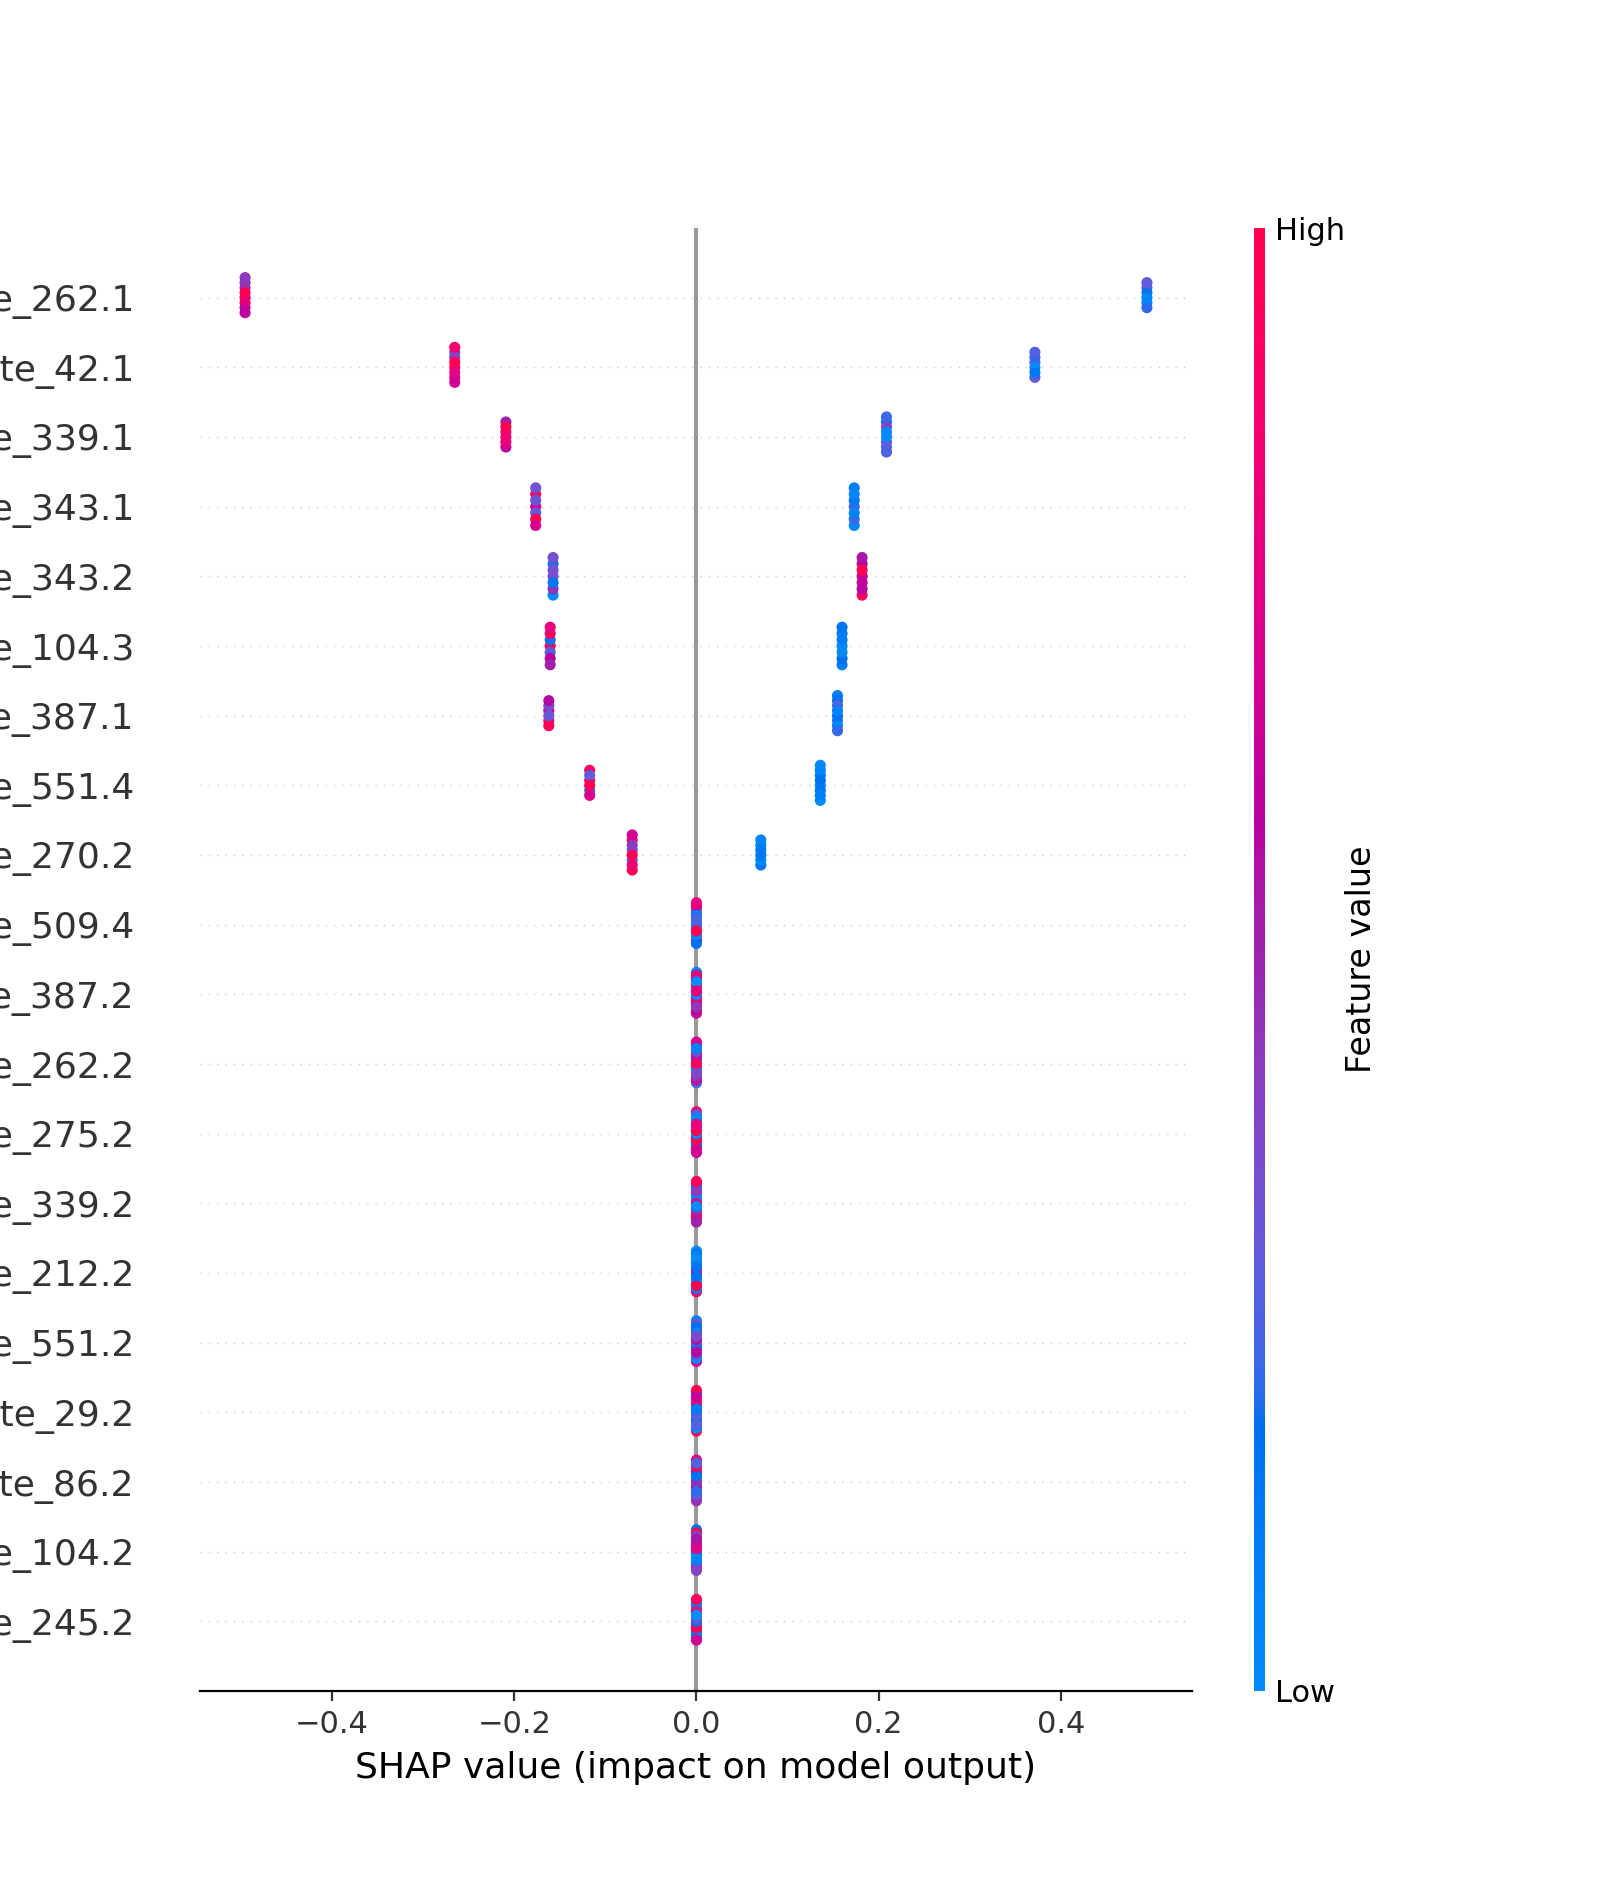

In [66]:
# matplotlib config
%matplotlib notebook

shap.summary_plot(shap_values, features=X_wide)

<IPython.core.display.Javascript object>


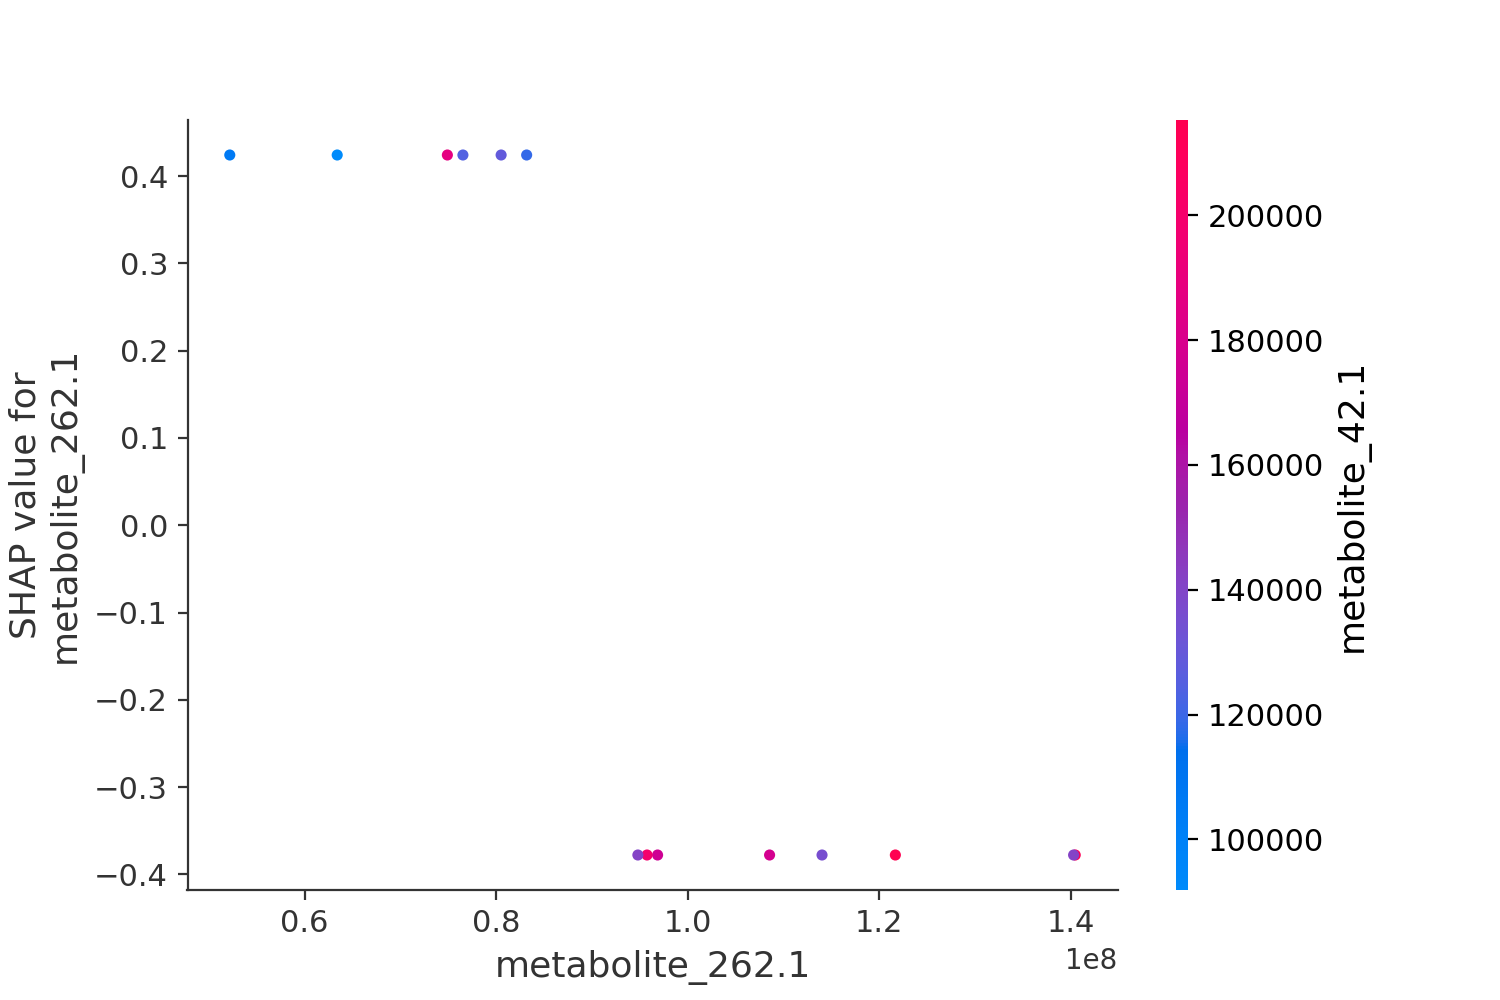

In [41]:
shap.dependence_plot('metabolite_262.1', shap_values, X_wide, interaction_index="metabolite_42.1")

In [43]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_wide.iloc[0,:])